In [ ]:
###### @authors: Lasith Adhikari and Anusha Madushani  #####
############ Created on Mar 22, 2020 (Python 3)############
# Updated on July 21, 2020
# Code description: 
# Detect and label for VAC events for mechanically ventialted patients - grouped version for Fio2 and Peep

In [1]:
## Imports all the packages. 
import numpy as np
import pandas as pd
import os
import pdb

import random
from IPython.core.display import display, HTML
import scipy.stats as stats
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
from google.colab import files
import os

In [ ]:
auth.authenticate_user() # authenticating 

In [ ]:
# from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# path to base folder (right click on the directory: SCCM 2020 Datathon, and select 'Add to my Drive' in order to appear on My Drive)
drive_folder = '/content/drive/My Drive/SCCM 2020 Datathon/' 

In [ ]:
# Note that this should be the project for the datathon work
project_id = 'sccm-datathon'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [ ]:
# function to label VAC or NO VAC for a given patient data - grouped version 
def is_VAC(df_, peep_change='low', fio2_change='low', min_baseline_period=2):

  # define groups:
  peep_gps = {'low':[0.99,3], 'med':[3,6], 'high':[6,100]} # Low=[1:3], Med=(3:6], High>6
  fio2_gps = {'low':[9.99,20], 'med':[20,50], 'high':[50,100]} # low=[10:20], med=(20:50], high>50

  # replace all 0 to 5  peep by 5:
  df = df_.copy()
  df.loc[(df['min_peep']>=0) & (df['min_peep']<=5), 'min_peep'] = 5

  for index, row in df.iterrows():

    peep_missing = False
    fio2_missing = False
    stable = np.nan

    if index >= min_baseline_period:

      #### check for stability end ####

      if ~df.loc[index-min_baseline_period: index-1,'min_peep'].isnull().any(): 
        # PEEP:
        if np.sum(df.loc[index-min_baseline_period: index-1,'min_peep'].diff()>0) == 0:
          peep_stable = True
        else:
          peep_stable = False
      else:
        peep_missing = True
    
      # FIO2:
      if ~df.loc[index-min_baseline_period: index-1,'min_fio2'].isnull().any(): 
        if np.sum(df.loc[index-min_baseline_period: index-1,'min_fio2'].diff()>0) == 0:
          fio2_stable = True
        else:
          fio2_stable = False
      else:
        fio2_missing = True

      if (peep_missing & fio2_missing):
        continue
      elif (peep_missing & ~fio2_missing):
        stable = fio2_stable
      elif (~peep_missing & fio2_missing):
        stable = peep_stable
      else:
        stable = (peep_stable & fio2_stable)

      #print(index)
      if not stable:
        if index == min_baseline_period:
          continue
        else: 
          break
      
  # pick max value within the stable baseline period: i.e. same as the first day value of the baseline period
  max_peep_stability_period = df.loc[index-min_baseline_period-1: index-min_baseline_period,'min_peep'].max()
  max_fio2_stability_period = df.loc[index-min_baseline_period-1: index-min_baseline_period,'min_fio2'].max()

  
  # generate variables to check if the worsening oxygenation period was sustained for 2 periods
  IsPeep_decs =  np.sum(df.loc[index-1: index,'min_peep'].diff()<0) # >0 if PEEP decreased after instability?
  IsFio2_decs =  np.sum(df.loc[index-1: index,'min_fio2'].diff()<0) # >0 if FiO2 decreased after instability?

  peep_change_now = (df.loc[index-1,'min_peep'] - max_peep_stability_period)
  fio2_change_now = (df.loc[index-1,'min_fio2'] - max_fio2_stability_period)
  isPeepChange_significant = (peep_change_now > peep_gps[peep_change][0]) & (peep_change_now <= peep_gps[peep_change][1])
  isFiO2Change_significant = (fio2_change_now > fio2_gps[fio2_change][0]) & (fio2_change_now <= fio2_gps[fio2_change][1])

  if (isPeepChange_significant & (IsPeep_decs==0)):
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'VAC', stable)
  elif (isFiO2Change_significant & (IsFio2_decs==0)):
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'VAC', stable)
  else:
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'No VAC', stable)


In [ ]:
# set the variable 'df_data_file' to the dataset that you are interested from the above list
df_data_file = 'data/eICU/1st_vent_ICU/day/eICU_day_MV_final.csv'  # CHANGE HERE
df_data = pd.read_csv(drive_folder + df_data_file) # read the dataset to df_data

# check for atleast 4 time periods for given id:
periods_per_id = df_data.groupby('patientunitstayid')['time_hr'].count()>=4
df_data = df_data[df_data.patientunitstayid.isin(periods_per_id[periods_per_id==True].index)].reset_index(drop=True)

# forward filling peep and fio2 within each id 
df_data.min_peep = df_data.groupby('patientunitstayid')['min_peep'].ffill()
df_data.min_fio2 = df_data.groupby('patientunitstayid')['min_fio2'].ffill()

# define grid of FiO2 and Peep values to be tested
delta_fio2  = ['low', 'med', 'high']    # CHANGE HERE. 
delta_peep  = ['low', 'med', 'high']    # CHANGE HERE. 

# define a dictionary to assign results and input parameters 
df_results = {'patientunitstayid': [], 'delta_fio2':[], 'delta_peep':[], 'unstable_start': [], 'unstable_end': [], 'VAC_outcome': [], 'IsStable':[]}

for d_fio2 in delta_fio2:
  for d_peep in delta_peep:
    print('Current iteration: delta_Fio2:',d_fio2, ',delta_Peep:',d_peep)
    i = 1 
    for enct_i in df_data.patientunitstayid.unique():
      df_i = df_data[df_data.patientunitstayid==enct_i].sort_values(by='time_hr').reset_index(drop=True)
      if (i%1000==0):
        print(i, 'patientunitstayids done...')
      result_i = is_VAC(df_i, peep_change=d_peep, fio2_change=d_fio2, min_baseline_period = 2)
      df_results['patientunitstayid'].append(result_i[0])
      df_results['delta_fio2'].append(d_fio2)
      df_results['delta_peep'].append(d_peep)
      df_results['unstable_start'].append(result_i[1])
      df_results['unstable_end'].append(result_i[2])
      df_results['VAC_outcome'].append(result_i[3])
      df_results['IsStable'].append(result_i[4])
      i+=1
df_results = pd.DataFrame(df_results)
df_results['VAC'] = df_results.VAC_outcome.apply(lambda x: 1 if x == 'VAC' else 0) # cat code for VAC label 

Current iteration: delta_Fio2: low ,delta_Peep: low
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
5000 patientunitstayids done...
6000 patientunitstayids done...
7000 patientunitstayids done...
8000 patientunitstayids done...
Current iteration: delta_Fio2: low ,delta_Peep: med
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
5000 patientunitstayids done...
6000 patientunitstayids done...
7000 patientunitstayids done...
8000 patientunitstayids done...
Current iteration: delta_Fio2: low ,delta_Peep: high
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
5000 patientunitstayids done...
6000 patientunitstayids done...
7000 patientunitstayids done...
8000 patientunitstayids done...
Current iteration: delta_Fio2: med ,delta_Peep: low
1000 patientunitstayids

In [ ]:
# Print results with VAC or No VAC label for each patient for different delta FiO2/Peep changes 
df_results

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC
0,141515.0,low,low,144,168,No VAC,True,0
1,141771.0,low,low,72,96,No VAC,True,0
2,142173.0,low,low,48,72,VAC,False,1
3,142388.0,low,low,48,72,No VAC,False,0
4,142416.0,low,low,72,96,No VAC,True,0
...,...,...,...,...,...,...,...,...
73885,3350812.0,high,high,48,72,No VAC,False,0
73886,3350892.0,high,high,96,120,No VAC,False,0
73887,3351176.0,high,high,96,120,No VAC,True,0
73888,3351414.0,high,high,96,120,No VAC,False,0


In [ ]:
#df_results.to_csv('eICU_1st_vent_ICU_VAC_calDay_grouped_july21.csv',index=False)
#files.download('eICU_1st_vent_ICU_VAC_calDay_grouped_july21.csv')

# load saved df_results data if needed:
#df_result_file = 'Results/eICU/eICU_1st_vent_ICU_VAC_24hr_jun20.csv'  # CHANGE HERE
#df_results = pd.read_csv(drive_folder + df_result_file) # read the dataset to df_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## NoVAC/VAC label vs. clinical outcome: ICU LOS

In [ ]:
#  Select in-hospital mortality outcome for all patients
df_status = run_query("""
select patientunitstayid, unitDischargeOffset 
from `physionet-data.eicu_crd.patient`
"""
)

In [ ]:
# convert to hours:
df_status.unitDischargeOffset = np.round(df_status.unitDischargeOffset/60.0,2)

In [ ]:
## Cleaning outcome
df_status = df_status[df_status.unitDischargeOffset>0]
print(df_status.unitDischargeOffset.describe())
#print('Median: ',np.median(df_status.unitDischargeOffset))
# encoding outcome to 1 (long stay) and 0 (short stay): 
df_status['Is_long_ICU_LOS'] =  df_status['unitDischargeOffset'].apply(lambda x: 1 if x > 240 else 0)  # is above 10 days at ICU? 

count    199646.000000
mean         64.693561
std         104.133938
min           0.020000
25%          19.880000
50%          38.080000
75%          71.580000
max       12152.930000
Name: unitDischargeOffset, dtype: float64


In [ ]:
df_status.Is_long_ICU_LOS.value_counts()

0    191418
1      8228
Name: Is_long_ICU_LOS, dtype: int64

In [ ]:
df_status.head()

,patientunitstayid,unitDischargeOffset,Is_long_ICU_LOS
0,1137569,154.10,0
1,486998,4.23,0
2,497557,0.10,0
3,1218211,14.07,0
4,2188050,18.65,0


In [ ]:
# Merge outcome:
df_vac_outcome = pd.merge(df_results, df_status[['patientunitstayid','unitDischargeOffset','Is_long_ICU_LOS']], how='left', on='patientunitstayid' )

# drop rows without outcome:
df_vac_outcome = df_vac_outcome[~df_vac_outcome.Is_long_ICU_LOS.isnull()]

# convert outcome to int
df_vac_outcome.Is_long_ICU_LOS = df_vac_outcome.Is_long_ICU_LOS.astype('int8')

In [ ]:
df_vac_outcome.head()

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC,unitDischargeOffset,Is_long_ICU_LOS
0,141515.0,low,low,144,168,No VAC,True,0,148.03,0
1,141771.0,low,low,72,96,No VAC,True,0,133.32,0
2,142173.0,low,low,48,72,VAC,False,1,622.22,1
3,142388.0,low,low,48,72,No VAC,False,0,140.12,0
4,142416.0,low,low,72,96,No VAC,True,0,99.70,0


In [ ]:
df_vac_outcome.patientunitstayid.nunique()

8210

In [ ]:
df_vac_outcome.Is_long_ICU_LOS.value_counts()

0    42498
1    31392
Name: Is_long_ICU_LOS, dtype: int64

In [ ]:
df_status[df_status.patientunitstayid.isin(df_vac_outcome.patientunitstayid)].unitDischargeOffset.describe()/24.0 # in days

count    342.083333
mean      11.340893
std        8.674941
min        4.000000
25%        6.132188
50%        8.886250
75%       13.498854
max      246.904167
Name: unitDischargeOffset, dtype: float64

## NoVAC/VAC label vs. clinical outcome: Mortaility

### Read mortality  outcome data

In [ ]:
#  Select in-hospital mortality outcome for all patients
df_status = run_query("""
select patientunitstayid, hospitaldischargestatus 
from `physionet-data.eicu_crd.patient`
"""
)

In [ ]:
# ditribution of data
df_status.hospitaldischargestatus.value_counts()

Alive      181104
Expired     18004
             1751
Name: hospitaldischargestatus, dtype: int64

In [ ]:
## Cleaning outcome
df_status = df_status[df_status.hospitaldischargestatus!='']
# encoding outcome to 1 and 0:
df_status['Inhospital_mortality'] =  df_status['hospitaldischargestatus'].apply(lambda x: 1 if x == 'Expired' else 0)

In [ ]:
df_status.head()

,patientunitstayid,hospitaldischargestatus,Inhospital_mortality
1751,3036927,Alive,0
1752,3058863,Alive,0
1753,3072720,Alive,0
1754,3097806,Alive,0
1755,3110061,Alive,0


In [ ]:
df_status.Inhospital_mortality.value_counts()

0    181104
1     18004
Name: Inhospital_mortality, dtype: int64

In [ ]:
# Merge outcome:
df_vac_outcome = pd.merge(df_vac_outcome, df_status, how='left', on='patientunitstayid' )

# drop rows without mortality outcome:
df_vac_outcome = df_vac_outcome[~df_vac_outcome.Inhospital_mortality.isnull()]

# convert Inhospital_mortality to int
df_vac_outcome.Inhospital_mortality = df_vac_outcome.Inhospital_mortality.astype('int8')

In [ ]:
df_vac_outcome.head()

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC,unitDischargeOffset,Is_long_ICU_LOS,hospitaldischargestatus,Inhospital_mortality
0,141515.0,low,low,144,168,No VAC,True,0,148.03,0,Expired,1
1,141771.0,low,low,72,96,No VAC,True,0,133.32,0,Alive,0
2,142173.0,low,low,48,72,VAC,False,1,622.22,1,Alive,0
3,142388.0,low,low,48,72,No VAC,False,0,140.12,0,Alive,0
4,142416.0,low,low,72,96,No VAC,True,0,99.70,0,Alive,0


In [ ]:
df_vac_outcome.patientunitstayid.nunique()

8124

## NoVAC/VAC label vs. clinical outcome: Hospital LOS

In [ ]:
#  Select in-hospital mortality outcome for all patients
df_status = run_query("""
select patientunitstayid, hospitalAdmitOffset, hospitalDischargeOffset 
from `physionet-data.eicu_crd.patient`
"""
)

In [ ]:
# compute hospital LOS
df_status['hospital_LOS_hrs'] = df_status['hospitalDischargeOffset'] - df_status['hospitalAdmitOffset']
df_status['hospital_LOS_hrs'] = np.round(df_status['hospital_LOS_hrs']/60, 2)

In [ ]:
df_status[df_status.patientunitstayid.isin(df_vac_outcome.patientunitstayid)].hospital_LOS_hrs.describe()/24.0 #in days

count    338.500000
mean      19.957538
std       17.095619
min        4.079167
25%       10.875625
50%       15.882292
75%       23.842500
max      600.767917
Name: hospital_LOS_hrs, dtype: float64

In [ ]:
df_status.head()

,patientunitstayid,hospitalAdmitOffset,hospitalDischargeOffset,hospital_LOS_hrs
0,1137569,-36707,23811,1008.63
1,3036927,-240,14302,242.37
2,3058863,-292,879,19.52
3,3088439,-1402,3771,86.22
4,3097806,-16114,5788,365.03


In [ ]:
## Cleaning outcome
df_status = df_status[df_status.hospital_LOS_hrs>0]
#print('Median: ',np.median(df_status.hospital_LOS_hrs))
# encoding outcome to 1 (long stay) and 0 (short stay): 
df_status['Is_long_Hosp_LOS'] =  df_status['hospital_LOS_hrs'].apply(lambda x: 1 if x > 384 else 0)  # use median of Hospital LOS from the VAC cohort

In [ ]:
df_status.head()

,patientunitstayid,hospitalAdmitOffset,hospitalDischargeOffset,hospital_LOS_hrs,Is_long_Hosp_LOS
0,1137569,-36707,23811,1008.63,1
1,3036927,-240,14302,242.37,0
2,3058863,-292,879,19.52,0
3,3088439,-1402,3771,86.22,0
4,3097806,-16114,5788,365.03,0


In [ ]:
# Merge outcome:
df_vac_outcome = pd.merge(df_vac_outcome, df_status[['patientunitstayid','hospital_LOS_hrs','Is_long_Hosp_LOS']], how='left', on='patientunitstayid' )

# drop rows without outcome:
df_vac_outcome = df_vac_outcome[~df_vac_outcome.Is_long_Hosp_LOS.isnull()]

# convert outcome to int
df_vac_outcome.Is_long_Hosp_LOS = df_vac_outcome.Is_long_Hosp_LOS.astype('int8')

In [ ]:
df_vac_outcome.patientunitstayid.nunique()

8124

In [ ]:
df_vac_outcome.head()

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC,unitDischargeOffset,Is_long_ICU_LOS,hospitaldischargestatus,Inhospital_mortality,hospital_LOS_hrs,Is_long_Hosp_LOS
0,141515.0,low,low,144,168,No VAC,True,0,148.03,0,Expired,1,173.03,0
1,141771.0,low,low,72,96,No VAC,True,0,133.32,0,Alive,0,420.05,1
2,142173.0,low,low,48,72,VAC,False,1,622.22,1,Alive,0,622.53,1
3,142388.0,low,low,48,72,No VAC,False,0,140.12,0,Alive,0,320.50,0
4,142416.0,low,low,72,96,No VAC,True,0,99.70,0,Alive,0,166.38,0


In [ ]:
df_vac_outcome.Is_long_Hosp_LOS.value_counts()

0    36999
1    36117
Name: Is_long_Hosp_LOS, dtype: int64

In [ ]:
#df_vac_outcome.to_csv('eICU_1st_vent_ICU_VAC_24hr_outcomes.csv',index=False)
df_vac_outcome.to_csv('eICU_1st_vent_ICU_VAC_calDay_outcomes_grouped_july21.csv',index=False)  # 
files.download('eICU_1st_vent_ICU_VAC_calDay_outcomes_grouped_july21.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analytics for each parameter setting

# Outcome:Mortality

In [ ]:
OR_results = {}
outcome_ = 'hospitaldischargestatus'

# define grid of FiO2 and Peep values to be tested
delta_fio2  = ['low', 'med', 'high']  # CHANGE HERE
delta_peep  = ['low', 'med', 'high']  # CHANGE HERE

for d_fio2 in delta_fio2:
  OR_results['dFio2:'+str(d_fio2)] = []
  for d_peep in delta_peep:
    print('Current parameter setting: delta_Fio2:',d_fio2, ', delta_Peep:',d_peep)

    df_analytics = df_vac_outcome[(df_vac_outcome.delta_fio2==d_fio2) & (df_vac_outcome.delta_peep==d_peep)]

    # VAC distribution:
    print('VAC distribution(%):')
    vac_distn = np.round(df_analytics.VAC_outcome.value_counts()/df_analytics.VAC_outcome.value_counts().sum()*100,2)
    #print(vac_distn.to_frame())
    print(tabulate(vac_distn.to_frame(), headers='keys', tablefmt='psql'))

    # Outcome distribution:
    print('Mortality distribution(%):')
    outcom_distn = np.round(df_analytics[outcome_].value_counts()/df_analytics[outcome_].value_counts().sum()*100,2)
    #print(outcom_distn.to_frame())
    print(tabulate(outcom_distn.to_frame(), headers='keys', tablefmt='psql'))

    # crosstab:
    print('Confusion matrix:')
    tbl = np.round(pd.crosstab(df_analytics.VAC_outcome, df_analytics[outcome_], dropna=False), 2)
    print(tabulate(tbl, headers='keys', tablefmt='psql'))

    # crosstab - percentage
    #print('Confusion matrix (%):')
    #tbl_perc = np.round(pd.crosstab(df_analytics.VAC_outcome, df_analytics.hospitaldischargestatus, dropna=False)/df_analytics.patientunitstayid.nunique()*100, 2)  
    #print(tabulate(tbl_perc, headers='keys', tablefmt='psql'))

    # compute odd-ratio:
    oddsratio, pvalue = stats.fisher_exact(np.array(tbl))
    print("Odds ratio: ", round(oddsratio,3), ", p-value:", pvalue) 

    OR_results['dFio2:'+str(d_fio2)].append(round(oddsratio,3))

    print('##########################-------------------------###############################')

# for visualization, generate table with OR for all different param.
index_list = []
for d_peep in delta_peep:
    index_list.append('dPeep:'+str(d_peep))
OR_results_df = pd.DataFrame(OR_results, index=index_list) 

print('####################################    SUMMARY   ####################################')
print(tabulate(OR_results_df, headers='keys', tablefmt='psql'))


Current parameter setting: delta_Fio2: low , delta_Peep: low
VAC distribution(%):
+--------+---------------+
|        |   VAC_outcome |
|--------+---------------|
| No VAC |         85.86 |
| VAC    |         14.14 |
+--------+---------------+
Mortality distribution(%):
+---------+---------------------------+
|         |   hospitaldischargestatus |
|---------+---------------------------|
| Alive   |                     81.34 |
| Expired |                     18.66 |
+---------+---------------------------+
Confusion matrix:
+---------------+---------+-----------+
| VAC_outcome   |   Alive |   Expired |
|---------------+---------+-----------|
| No VAC        |    5717 |      1258 |
| VAC           |     891 |       258 |
+---------------+---------+-----------+
Odds ratio:  1.316 , p-value: 0.0005063660809598569
##########################-------------------------###############################
Current parameter setting: delta_Fio2: low , delta_Peep: med
VAC distribution(%):
+--------+----

#### Odd ratio visualization

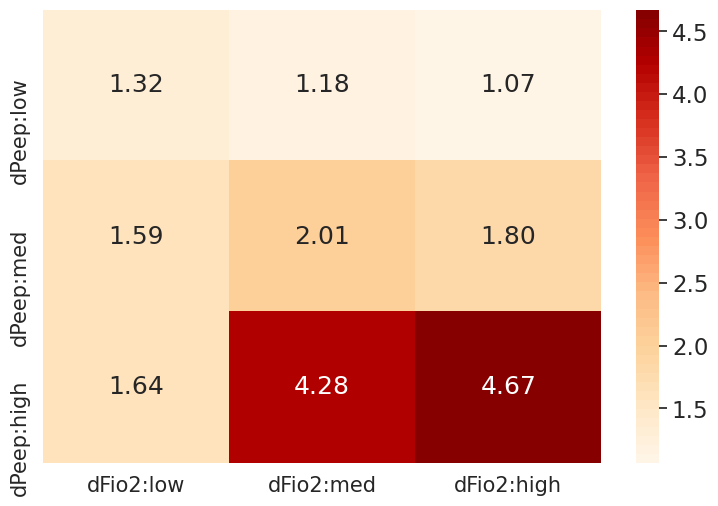

In [ ]:
# 
sns.set(font_scale=1.5)  # crazy big
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
ax = sns.heatmap(OR_results_df, annot=True, cmap=sns.color_palette("OrRd", 50), fmt='.2f')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)